In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#distance
import gower

# 
import importlib
import utils
importlib.reload(utils)

import models
importlib.reload(models)

import preprocessing
importlib.reload(preprocessing)
import torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchsummary
from torch.nn import functional as F

from torch.utils.data import Dataset, DataLoader

sns.set_palette('Set2')

In [2]:
df = preprocessing.load_dataset()
data_tensor = torch.tensor(df.to_numpy(), dtype=torch.float32)
binary_indices = utils.binary_indices

In [3]:
class DataFrameDataset(Dataset):
    def __init__(self, dataframe):
        # Assuming dataframe is already scaled and prepared for neural network input
        self.data = torch.tensor(dataframe.values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Returns a sample from the dataset
        return self.data[idx]
def create_dataloader(df, batch_size=32, shuffle=True):
    dataset = DataFrameDataset(df)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader
dataloader = create_dataloader(df, batch_size=10, shuffle=True)

In [4]:
from torch import nn
class Autoencoder(nn.Module):
    def __init__(self, binary_indices):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=21, out_features=16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 21)
        )
        self.binary_indices = binary_indices

    def forward(self, x):
        x_encoded = self.encoder(x)
        x_reconstructed = self.decoder(x_encoded)
        return x_reconstructed

In [5]:
model = Autoencoder(binary_indices = binary_indices)
torchsummary.summary(model);

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       352
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       136
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       36
├─Sequential: 1-2                        --
|    └─Linear: 2-6                       40
|    └─ReLU: 2-7                         --
|    └─Linear: 2-8                       144
|    └─ReLU: 2-9                         --
|    └─Linear: 2-10                      357
Total params: 1,065
Trainable params: 1,065
Non-trainable params: 0


In [8]:

def gower_loss(x_original, x_reconstructed, binary_indices, continuous_indices):
    # Binary indices handling
    alpha = len(binary_indices)/(len(binary_indices) + len(continuous_indices))
    x_bin_original = x_original[:, binary_indices]
    x_bin_reconstructed = torch.sigmoid(x_reconstructed[:, binary_indices])

    # Binary loss (using BCE)
    binary_loss = F.binary_cross_entropy_(x_bin_reconstructed, x_bin_original, reduction='mean')

    # Continuous data handling
    continuous_indices = [i for i in range(x_original.shape[1]) if i not in binary_indices]
    x_cont_original = x_original[:, continuous_indices]
    x_cont_reconstructed = x_reconstructed[:, continuous_indices]

    # Continuous loss (using MSE)
    continuous_loss = F.mse_loss(x_cont_reconstructed, x_cont_original, reduction='mean')

    # Combine losses
    total_loss = alpha * binary_loss + (1 - alpha) * continuous_loss
    return total_loss

In [9]:
epochs = 50
importlib.reload(utils)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(epochs):
    for data in dataloader:
        model.train()
        optimizer.zero_grad()
        x_reconstructed = model(data)
        loss = gower_loss(data, 
                                x_reconstructed, 
                                utils.binary_indices,
                                utils.continuous_indices)
        loss.backward()
        optimizer.step()
        # Step the scheduler
    scheduler.step()
    if epoch % 15 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, LR: {scheduler.get_last_lr()[0]}')
print("Training complete")

Epoch [1/50], Loss: 0.1112, LR: 0.01
Epoch [16/50], Loss: 0.0569, LR: 0.001
Epoch [31/50], Loss: 0.0287, LR: 1e-05
Epoch [46/50], Loss: 0.0187, LR: 1.0000000000000002e-06
Training complete


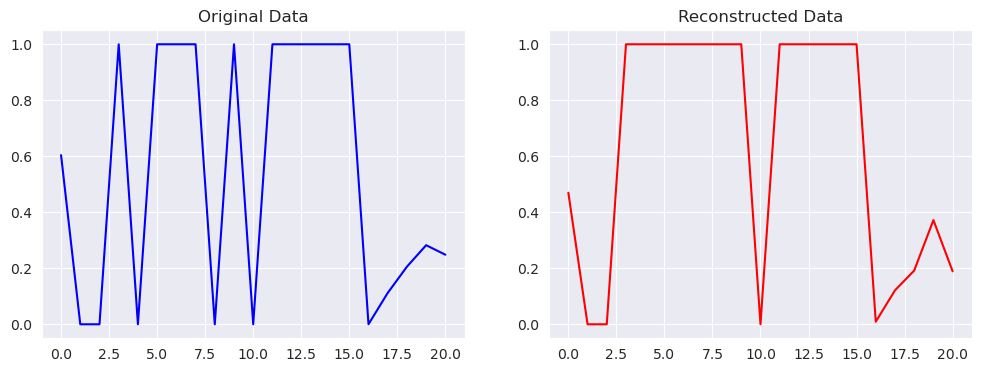

In [11]:
model.eval()
test_output = model(data_tensor)

index = 1
index = 1626
# Plot original and reconstructed data
original_data = data_tensor.numpy()[index]
reconstructed_data = test_output.detach().numpy()[index]
reconstructed_data[binary_indices] = (reconstructed_data[binary_indices] > 0.5)
#reconstructed_data[binary_indices] = (reconstructed_data[binary_indices])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].plot(original_data, 'b')
axes[0].set_title('Original Data')
axes[1].plot(reconstructed_data, 'r')
axes[1].set_title('Reconstructed Data')
plt.show()